In [ ]:
# Importing necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
import pickle as pickle
import os

In [ ]:
data = pd.read_excel("/content/employee_burnout_analysis-AI.xlsx")
data.shape

(22750, 9)

In [ ]:
def preprocess_inputs(df):
    df = df.copy()

    # Drop Employee ID column
    df = df.drop('Employee ID', axis=1)

    # Drop rows with missing target values
    missing_target_rows = df.loc[df['Burn Rate'].isna(), :].index
    df = df.drop(missing_target_rows, axis=0).reset_index(drop=True)

    # Fill remaining missing values with column means
    for column in ['Resource Allocation', 'Mental Fatigue Score']:
        df[column] = df[column].fillna(df[column].mean())

    # Extract date features
    df['Date of Joining'] = pd.to_datetime(df['Date of Joining'])
    df['Join Month'] = df['Date of Joining'].apply(lambda x: x.month)
    df['Join Day'] = df['Date of Joining'].apply(lambda x: x.day)
    df = df.drop('Date of Joining', axis=1)

    # Binary encoding
    df['Gender'] = df['Gender'].replace({'Female': 0, 'Male': 1})
    df['Company Type'] = df['Company Type'].replace({'Product': 0, 'Service': 1})
    df['WFH Setup Available'] = df['WFH Setup Available'].replace({'No': 0, 'Yes': 1})

    # Split df into X and y
    y = df['Burn Rate']
    X = df.drop('Burn Rate', axis=1)

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, shuffle=True, random_state=1)

    # Scale X
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train = pd.DataFrame(scaler.transform(X_train), index=X_train.index, columns=X_train.columns)
    X_test = pd.DataFrame(scaler.transform(X_test), index=X_test.index, columns=X_test.columns)

    return X_train, X_test, y_train, y_test

In [ ]:
data.describe()

In [ ]:
data.columns.tolist()

In [ ]:
data.nunique()

In [ ]:
data.info()

In [ ]:
data.isnull().sum()

In [ ]:
data.isnull().sum().values.sum()

In [ ]:
data.corr(numeric_only=True)['Burn Rate'][:-1]

Designation             0.737556
Resource Allocation     0.856278
Mental Fatigue Score    0.944546
Name: Burn Rate, dtype: float64

## Exploratory Data Analysis

# New Section

These two variables are strongly correlated with target variable, therefore , important to estimate it.

In [ ]:
sns.pairplot(data)
plt.show()

Drop off all observations with NaN values of our dataframe.

In [ ]:
data = data.dropna()

In [ ]:
data.shape

(22750, 9)

In [ ]:
data.shape

(22750, 9)

Analyzing what type of data is each variable.

In [ ]:
data.dtypes

Employee ID              object
Gender                   object
Company Type             object
WFH Setup Available      object
Designation               int64
Resource Allocation     float64
Mental Fatigue Score    float64
Burn Rate               float64
dtype: object

In [ ]:
data.dtypes

Employee ID              object
Gender                   object
Company Type             object
WFH Setup Available      object
Designation               int64
Resource Allocation     float64
Mental Fatigue Score    float64
Burn Rate               float64
dtype: object

 The values that each variable contains.

In [ ]:
data_obj = data.select_dtypes(object)
# prints a dictionary of max 10 unique values for each non-numeric column
print({ c : data_obj[c].unique()[:10] for c in data_obj.columns})


{'Employee ID': array(['fffe32003000360033003200', 'fffe3700360033003500',
       'fffe31003300320037003900', 'fffe32003400380032003900',
       'fffe31003900340031003600', 'fffe3300350037003500',
       'fffe33003300340039003100', 'fffe32003600320037003400',
       'fffe32003200300034003700', 'fffe31003600320030003200'],
      dtype=object), 'Gender': array(['Female', 'Male'], dtype=object), 'Company Type': array(['Service', 'Product'], dtype=object), 'WFH Setup Available': array(['No', 'Yes'], dtype=object)}




```
# This is formatted as code
```

 The employees ID doesn't provide any useful information and, therefore, they must be dropped.

In [ ]:
data = data.drop('Employee ID', axis = 1)


Checking the correlation of Date of Joining with Target variable

Min date 2008-01-01 00:00:00
Max date 2008-12-31 00:00:00


<Axes: xlabel='Month', ylabel='Hired employees'>

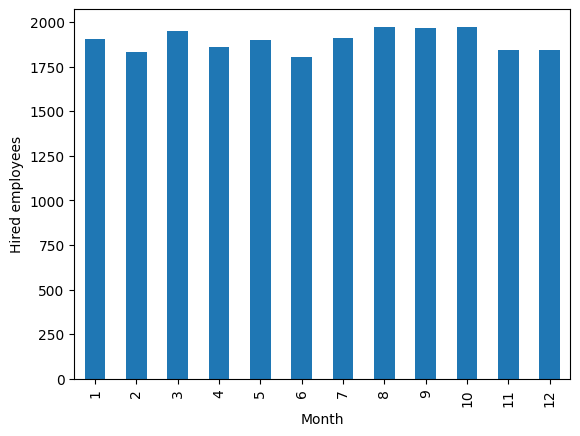

In [ ]:
print(f"Min date {data['Date of Joining'].min()}")
print(f"Max date {data['Date of Joining'].max()}")
data_month = data.copy()

data_month["Date of Joining"] = data_month['Date of Joining'].astype("datetime64[ns]")
data_month["Date of Joining"].groupby(
    data_month['Date of Joining'].dt.month
).count().plot(kind="bar", xlabel='Month', ylabel="Hired employees")

 The date of joining is uniform distributed with values between 2008-01-01 and 2008-12-31. So in order to create a new feature which represents the labor seniority, we could create a variable with de days worked

In [ ]:
data_2008 = pd.to_datetime(["2008-01-01"]*len(data))
data["Days"] = data['Date of Joining'].astype("datetime64[ns]").sub(data_2008).dt.days
data.Days

0        273
1        334
2         69
3        307
4        205
        ... 
22745    364
22746     18
22747    309
22748      9
22749      5
Name: Days, Length: 22750, dtype: int64

In [ ]:
data.corr(numeric_only=True)['Burn Rate'][:]

Designation             0.737556
Resource Allocation     0.856278
Mental Fatigue Score    0.944546
Burn Rate               1.000000
Days                   -0.001358
Name: Burn Rate, dtype: float64

We observed that there is no strong correlation between Date of Joining and Burn Rate.So, we are dropping the column Date of Joining.

In [ ]:
data = data.drop(['Date of Joining','Days'], axis = 1)

In [ ]:
data.head()

,Employee ID,Gender,Company Type,WFH Setup Available,Designation,Resource Allocation,Mental Fatigue Score,Burn Rate
0,fffe32003000360033003200,Female,Service,No,2,3.0,3.8,0.16
1,fffe3700360033003500,Male,Service,Yes,1,2.0,5.0,0.36
2,fffe31003300320037003900,Female,Product,Yes,2,NaN,5.8,0.49
3,fffe32003400380032003900,Male,Service,Yes,1,1.0,2.6,0.20
4,fffe31003900340031003600,Female,Service,No,3,7.0,6.9,0.52


Now  analysing the categorical variables

In [ ]:
cat_columns = data.select_dtypes(object).columns
fig, ax = plt.subplots(nrows=1, ncols=len(cat_columns), sharey=True, figsize=(10, 5))
for i, c in enumerate(cat_columns):
    sns.countplot(x=c, data=data, ax=ax[i])
plt.show()


The number of observations of each category on each variable is equally distributed, except to the Company_Type where the number of service jobs its almost twice that of product ones.


In [ ]:
data.columns

In [ ]:
data = pd.get_dummies(data, columns=['Company Type', 'WFH Setup Available',
       'Gender'], drop_first=True)
data.head()
encoded_columns = data.columns